In [3]:
import importlib, data, LSTM_returns, optimization
import pandas as pd
import numpy as np
importlib.reload(data)

<module 'data' from 'c:\\Users\\Ian Chen-Adamczyk\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [4]:
importlib.reload(data)


# Step 1: load each asset's df using data module
SOL_df = data.load_asset('SOLUSDT')        # Solana


dfs = {
    'SOL': SOL_df,
}


In [5]:
importlib.reload(data)

# Step 2: pre-process each asset's df using the data module
for key, df in dfs.items():
    print(f"{key} is available for range {data.get_min_max_time(df)}")

    df = df.copy()
    df = data.subset(df, start=pd.Timestamp('2021-01-01 08:00:00'), end=pd.Timestamp('2026-01-01'))
    data.report_and_print_gaps(df)
    df = data.add_returns(df)
    df.dropna(inplace=True)
    df = data.normalize_data(df)
    df = data.train_test_split(df, split=0.8)
    dfs[key] = df

    print("\n")

SOL is available for range (Timestamp('2020-08-11 06:00:00'), Timestamp('2025-03-31 23:30:00'))
Gap of 0 days 01:30:00 		 from 2021-02-11 03:30:00 to 2021-02-11 05:00:00
Gap of 0 days 02:00:00 		 from 2021-03-06 01:30:00 to 2021-03-06 03:30:00
Gap of 0 days 03:00:00 		 from 2021-04-20 01:30:00 to 2021-04-20 04:30:00
Gap of 0 days 04:30:00 		 from 2021-04-25 04:00:00 to 2021-04-25 08:30:00
Gap of 0 days 05:00:00 		 from 2021-08-13 01:30:00 to 2021-08-13 06:30:00
Gap of 0 days 02:30:00 		 from 2021-09-29 06:30:00 to 2021-09-29 09:00:00
Gap of 0 days 01:30:00 		 from 2023-03-24 12:30:00 to 2023-03-24 14:00:00




In [6]:
[df.shape for df in dfs.values()]

[(74397, 12)]

In [7]:
importlib.reload(LSTM_returns)

# Step 3: create and train LSTMs using various hyperparameters using the LSTM_returns module
LSTMs = {}
train_X_y_s = {}

for key, df in dfs.items():
    print(f"TRAINING {key}")

    features = df.columns
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume']
    target = "Return"

    train_X_y = LSTM_returns.vectorize_train_data(df, target=target, features=features, episode_length=5)
    train_X_y_s[key] = train_X_y

    hyperparams = {
        'input_shape': train_X_y['train_X'].shape[1:],
        
    }

    LSTM = LSTM_returns.create(hyperparams)

    LSTM_returns.train(LSTM, hyperparams, train_X_y)

    LSTMs[key] = LSTM

TRAINING SOL


C:\Users\Ian Chen-Adamczyk\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0299 - mae: 0.0657
Epoch 2/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5.3262e-04 - mae: 0.0179
Epoch 3/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 4.5545e-04 - mae: 0.0167
Epoch 4/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 4.2231e-04 - mae: 0.0161
Epoch 5/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.9808e-04 - mae: 0.0156
Epoch 6/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.8145e-04 - mae: 0.0151
Epoch 7/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 3.7837e-04 - mae: 0.0151
Epoch 8/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.6981e-04 - mae: 0.0149
Epoch 9/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 3.5147e-04 - mae: 0.0145
Epoch 10/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 3.3708e-04 - mae: 0.0140
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


In [12]:
pred_r_s = LSTMs["SOL"].predict(train_X_y_s["SOL"]['test_X'])
pred_r_s

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[0.06717142],
       [0.06695232],
       [0.06610474],
       ...,
       [0.05019912],
       [0.05161503],
       [0.05117384]], dtype=float32)

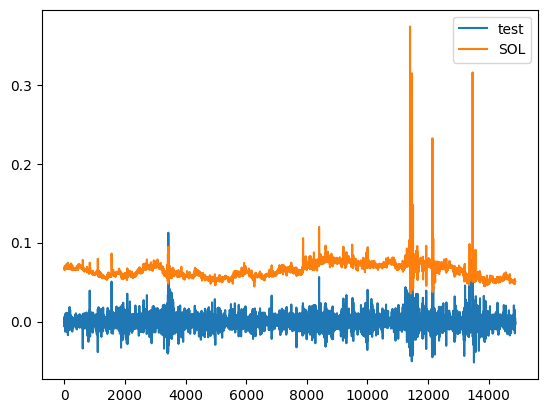

In [15]:
import matplotlib.pyplot as plt

look_at = 'SOL'
dummy_times = range(len(train_X_y_s[look_at]['test_y']))
plt.plot(dummy_times, train_X_y_s[look_at]['test_y'], label='test')
plt.plot(dummy_times, pred_r_s, label=look_at)
plt.legend()
plt.show()

In [9]:
SOL_df["Re"]

KeyError: 'Re'

In [ ]:
LSTMs["SOL"].predict(train_X_y_s["SOL"]['test_X'])

train_X_y_s["SOL"]['test_X']

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[[0.57438169, 0.56686565, 0.58450219, ..., 0.00793085,
         0.0101848 , 0.01229493],
        [0.57586648, 0.56781722, 0.58580304, ..., 0.00844323,
         0.01261371, 0.01525951],
        [0.57586648, 0.56693362, 0.58411545, ..., 0.00662633,
         0.00583074, 0.00703424],
        [0.5738292 , 0.56571017, 0.58348261, ..., 0.00624074,
         0.00827455, 0.0099724 ],
        [0.57324219, 0.56621994, 0.58351777, ..., 0.00551147,
         0.00556689, 0.00671101]],

       [[0.57586648, 0.56781722, 0.58580304, ..., 0.00844323,
         0.01261371, 0.01525951],
        [0.57586648, 0.56693362, 0.58411545, ..., 0.00662633,
         0.00583074, 0.00703424],
        [0.5738292 , 0.56571017, 0.58348261, ..., 0.00624074,
         0.00827455, 0.0099724 ],
        [0.57324219, 0.56621994, 0.58351777, ..., 0.00551147,
         0.00556689, 0.00671101],
        [0.57407092, 0.56499649, 0.58098639, ..., 0.00964507,
         0.01201455, 0.01442283]],

       [[0.57586648, 0.56693362, 0.5

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs('expt-2-model-store', exist_ok=True)

# Save each LSTM model to a separate file
for key, model in LSTMs.items():
    model_path = f'expt-2-model-store/{key}.keras'
    model.save(model_path)
    print(f"Saved {key} model to {model_path}")


Saved SOL model to expt-2-model-store/SOL.keras


In [ ]:
dfs.__delitem__('MATIC')
LSTMs.__delitem__('MATIC')
train_X_y_s.__delitem__('MATIC')

KeyError: 'MATIC'

In [ ]:
# Step 5: get LSTM predictions
pre_s = {}
for key in LSTMs.keys():
    pre_s[key] = LSTMs[key].predict(train_X_y_s[key]['test_X'])

T = len(pre_s[key])
pred_r_s = {key: value.flatten() for key, value in pre_s.items()}

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
import numpy as np
importlib.reload(optimization)


# 3) Build the full (T,3) mu_preds array:
#    [ r_xlm(t), r_btc(t), 0.0 ]
mu_preds = np.vstack([
    *pred_r_s.values(),
    np.zeros(T)                # stable asset return is always zero
]).T                            # now shape (T,3)

# 4) Set up the loop
n = len(pred_r_s.values()) + 1
w_prev  = np.ones(n) / n         # e.g. start [1/3,1/3,1/3]
weights = np.zeros((T, n))

for t in range(T):
    mu_t  = mu_preds[t]          # shape (3,)
    w_new = optimization.max_return_with_turnover(
                mu=mu_t,
                w_prev=w_prev,
                turnover_penalty=10.0,  # tune to your strategy
                long_only=True
            )
    weights[t] = w_new
    w_prev    = w_new

: 

In [ ]:
import matplotlib.pyplot as plt

# dates = T = len(r_xlm)   # your test‐set timestamps, length T
df_w  = pd.DataFrame(
    weights,
    # dates,
    columns=[*[f"{tick}_weight" for tick in dfs.keys()], "Stable_weight"]
)

dummy_times = range(0, len(df_w))

plt.figure()
for col in df_w.columns:
    plt.plot(dummy_times, df_w[col], label=col)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Weight')
plt.title('Portfolio Weights Over Time')
plt.show()


NameError: name 'weights' is not defined

In [ ]:
look_at = 'SOL'
plt.plot(dummy_times, train_X_y_s[look_at]['test_y'], label='test')
plt.plot(dummy_times, pred_r_s[look_at], label=look_at)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

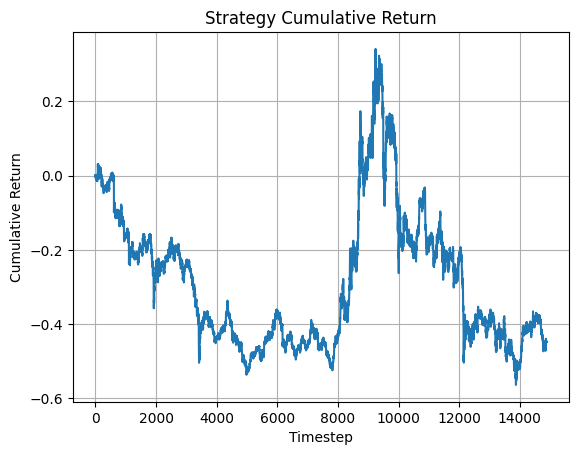

In [ ]:
rets = {key: dfs[key].loc[train_X_y_s[key]['test_index']]["Return"] for key in dfs.keys()}
ret_stable = np.zeros_like(rets["BTC"])
realized_rets = np.vstack([*rets.values(), ret_stable]).T     

port_rets = (weights * realized_rets).sum(axis=1)
cum_rets = np.cumprod(1 + port_rets) - 1
plt.plot(cum_rets)
plt.xlabel('Timestep')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Return')
plt.grid(True)
plt.show()

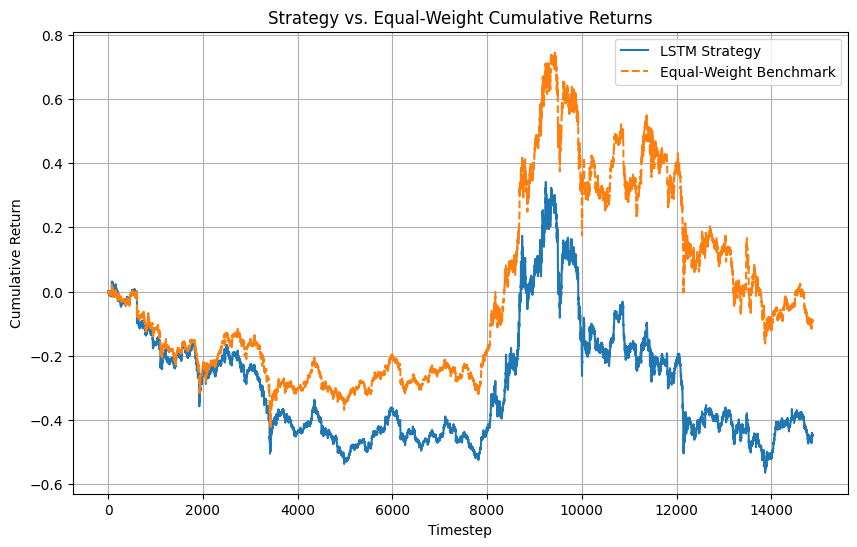

In [ ]:
port_rets   = (weights * realized_rets).sum(axis=1)        # (T,)
cum_rets    = np.cumprod(1 + port_rets) - 1               # (T,)

# 2) equal‑weight benchmark
n_assets    = weights.shape[1]
equal_w     = np.ones(n_assets) / n_assets                # (n_assets,)
eq_rets     = realized_rets.dot(equal_w)                  # (T,)
cum_eq_rets = np.cumprod(1 + eq_rets) - 1                 # (T,)

# 3) plot both
plt.figure(figsize=(10,6))
plt.plot(cum_rets,    label='LSTM Strategy')
plt.plot(cum_eq_rets, label='Equal‑Weight Benchmark', linestyle='--')
plt.xlabel('Timestep')
plt.ylabel('Cumulative Return')
plt.title('Strategy vs. Equal‑Weight Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 6: compare to a buy-and-hold benchmark using PyPortfolioOpt to get returns at each step.

import numpy as np
import pandas as pd
from pypfopt.expected_returns     import mean_historical_return
from pypfopt.risk_models          import sample_cov, CovarianceShrinkage
from pypfopt.efficient_frontier    import EfficientFrontier


train_idx = list(train_X_y_s.values())[0]['train_index']
raw_dfs = {key: data.load_asset(key) for key in dfs.keys()}
prices = {key: df.loc[train_idx, "Close"].rename(key) for key, df in raw_dfs.items()}


# 1) Build & clean your 2‑asset price DataFrame
prices_risky = pd.concat(prices.items(), axis=1)
prices_risky = (
    prices_risky
    .apply(pd.to_numeric, errors="coerce")  # force floats, NaN out non‑numeric
    .replace([0, np.inf, -np.inf], np.nan)
    .dropna()
)

# 2) Annualize at 30‑min (48×365)
freq = 48 * 365

# 3) Compute expected returns
mu_r = mean_historical_return(prices_risky, frequency=freq)

# 4A) OPTION A: Ledoit‑Wolf shrinkage (recommended)
cs       = CovarianceShrinkage(prices_risky, frequency=freq)
Sigma_r  = cs.ledoit_wolf()

# 4B) OPTION B: add a tiny diagonal jitter to your sample covariance
# Sigma_r = sample_cov(prices_risky, frequency=freq)
# Sigma_r += 1e-4 * np.eye(Sigma_r.shape[0])

# 5) Solve for the max‑Sharpe (risky) weights
ef       = EfficientFrontier(mu_r, Sigma_r, weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=0.0)   # cash return = 0
w_risky  = ef.clean_weights()       # e.g. {'XLM':0.3,'BTC':0.6}

# 6) Allocate the remainder to cash
w_risky['Stable'] = 1 - sum(w_risky.values())

print("Max‑Sharpe w/ cash:", w_risky)



KeyError: "None of [DatetimeIndex(['2021-01-01 10:00:00', '2021-01-01 10:30:00',\n               '2021-01-01 11:00:00', '2021-01-01 11:30:00',\n               '2021-01-01 12:00:00', '2021-01-01 12:30:00',\n               '2021-01-01 13:00:00', '2021-01-01 13:30:00',\n               '2021-01-01 14:00:00', '2021-01-01 14:30:00',\n               ...\n               '2024-05-25 18:00:00', '2024-05-25 18:30:00',\n               '2024-05-25 19:00:00', '2024-05-25 19:30:00',\n               '2024-05-25 20:00:00', '2024-05-25 20:30:00',\n               '2024-05-25 21:00:00', '2024-05-25 21:30:00',\n               '2024-05-25 22:00:00', '2024-05-25 22:30:00'],\n              dtype='datetime64[ns]', name='Open time', length=59513, freq=None)] are in the [index]"

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# assume you already have:
#   mu_r   → pd.Series of expected returns for ['XLM','BTC']
#   Sigma_r → pd.DataFrame covariance matrix for ['XLM','BTC']

# 1) Inspect μ
print("Estimated expected returns:")
print(mu_r)

# 2) Compute an adjusted RF just below the minimum μ
min_mu = mu_r.min()
rf_adj = min_mu - 1e-6
print(f"Adjusting risk-free rate to {rf_adj:.6f}")

# 3) Solve max‑Sharpe with the adjusted RF
ef = EfficientFrontier(mu_r, Sigma_r, weight_bounds=(0,1))
ef.max_sharpe(risk_free_rate=rf_adj)
w_risky = ef.clean_weights()

# 4) Allocate remainder to cash
w_risky['Stable'] = 1 - sum(w_risky.values())

print("Max‑Sharpe w/ adjusted RF:", w_risky)


print(prices_risky)


Estimated expected returns:
XLM   -0.515079
BTC   -0.505002
dtype: float64
Adjusting risk-free rate to -0.515080
Max‑Sharpe w/ adjusted RF: OrderedDict({'XLM': 0.0, 'BTC': 1.0, 'Stable': 0.0})
